In [1]:
import numpy as np
import collections
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
import csv
import re
import pylab

In [2]:
MAX_DOCUMENT_LENGTH = 100
HIDDEN_SIZE = 20
EMBEDDING_SIZE = 20
MAX_LABEL = 15

batch_size = 128
no_epochs = 100
lr = 0.01

seed = 10
tf.random.set_seed(seed)

In [3]:
def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text

In [4]:
def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict

In [5]:
def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x

In [6]:
def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('/content/drive/My Drive/tensorflow/train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('/content/drive/My Drive/tensorflow/test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size

In [7]:
x_train, y_train, x_test, y_test, vocab_size = read_data_words()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [8]:
# Build model
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=10):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(tf.keras.layers.GRUCell(self.hidden_dim), unroll=True) # GRU #, return_sequences=True
        #self.rnn2 = layers.RNN(tf.keras.layers.GRUCell(self.hidden_dim), unroll=True) # GRU2
        #self.rnn = layers.RNN(tf.keras.layers.SimpleRNNCell(self.hidden_dim), unroll=True) # Vanilla RNN
        #self.rnn = layers.RNN(tf.keras.layers.LSTMCell(self.hidden_dim), unroll=True) # LSTM
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)
        #encoding = self.rnn2(encoding)
        #encoding = tf.nn.dropout(encoding, drop_rate) # Question 5
        logits = self.dense(encoding)
    
        return logits

In [9]:
model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipvalue = 2) #Gradient Clipping 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [10]:
# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

In [11]:
# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)


In [12]:
test_acc = []
train_lo = []
for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    test_acc.append(test_accuracy.result())
    train_lo.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))

Epoch 1, Loss: 2.7056334018707275, Accuracy: 0.06785714626312256, Test Loss: 2.7040364742279053, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.7045235633850098, Accuracy: 0.06803571432828903, Test Loss: 2.7038774490356445, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.704253911972046, Accuracy: 0.06535714119672775, Test Loss: 2.7037079334259033, Test Accuracy: 0.07285714149475098
Epoch 4, Loss: 2.703552722930908, Accuracy: 0.08178571611642838, Test Loss: 2.700599431991577, Test Accuracy: 0.13285714387893677
Epoch 5, Loss: 2.6368448734283447, Accuracy: 0.16107143461704254, Test Loss: 2.5728304386138916, Test Accuracy: 0.21142856776714325
Epoch 6, Loss: 2.530618906021118, Accuracy: 0.29249998927116394, Test Loss: 2.4829037189483643, Test Accuracy: 0.3442857265472412
Epoch 7, Loss: 2.432058095932007, Accuracy: 0.4028571546077728, Test Loss: 2.3805572986602783, Test Accuracy: 0.5042856931686401
Epoch 8, Loss: 2.3316562175750732, Accuracy: 0.5107142925262451, Test Loss: 2.31976890

Text(0, 0.5, 'Train Loss')

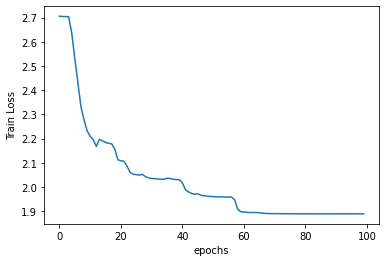

In [13]:
# Plot train loss
pylab.figure()
pylab.plot(np.arange(no_epochs), train_lo)
pylab.xlabel('epochs')
pylab.ylabel('Train Loss')

Text(0, 0.5, 'Test Accuracy')

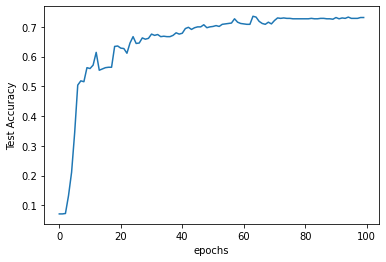

In [14]:
# Plot test accuracy
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc)
pylab.xlabel('epochs')
pylab.ylabel('Test Accuracy')